# Term Project: Spatiotemporal Wildfire Prediction using Hybrid RF-GA
**By:** Adit Dhall  

**Objective:** Compare a standard Random Forest baseline (Hong et al.) against a custom Evolutionary Search (GA). 

**Hypothesis:** A standard GA based purely on physics (slope/fuel) might miss historical context. We test a "Naive GA" first, then upgrade it to a "History-Aware GA" to see if results improve.


### 1. Setup and Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from scipy.spatial import cKDTree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# --- REPRODUCIBILITY SETUP ---
# critical for ensuring results don't jump around between runs
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# plot styling for the poster
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 6)})

print(f"Libraries loaded. Global Seed set to {SEED}.")

Libraries loaded. Global Seed set to 42.


### 2. Data Loading

In [2]:
# simple loader with error handling
def load_data(filename):
    try:
        # found latin-1 works better for these csv headers
        df = pd.read_csv(filename, encoding='latin-1')
        print(f"Loaded {os.path.basename(filename)}: {len(df)} rows")
        return df
    except FileNotFoundError:
        print(f"ERROR: {filename} not found.")
        return None

# adjusting paths for local machine
base_path = 'data/'
train_df = load_data(base_path + 'wildfire_train_with_DEM.csv')
val_df   = load_data(base_path + 'wildfire_val_with_DEM.csv')
test_df  = load_data(base_path + 'wildfire_test_with_DEM.csv')

if train_df is None or test_df is None:
    raise ValueError("Data missing. Check paths.")

Loaded wildfire_train_with_DEM.csv: 78456 rows
Loaded wildfire_val_with_DEM.csv: 16812 rows
Loaded wildfire_test_with_DEM.csv: 16812 rows


### 3. Feature Engineering
Defining the state space based on literature (Hong et al., 2018). We use NDVI (Vegetation), Topography (Elevation/Slope), and standard Met data.

In [3]:
# --- Feature Space ---
# 1. Spatial: Lat/Lon
# 2. Vegetation: NDVI
# 3. Topo: Elevation, Slope
# 4. Met: Temp, Vapor Pressure, etc.

feature_candidates = [
    'latitude', 'longitude', 
    'ndvi_modis', 
    'elevation', 'slope',
    'tmmn', 'tmmx', 'vpd', 
    'pr', 'rmax', 'vs',
    'erc' # energy release component
]

# filter to keep only what's actually in the csv
features = [f for f in feature_candidates if f in train_df.columns]
print(f"Selected Features: {features}")

# cleaning up NAs
train_df = train_df.dropna(subset=features)
val_df = val_df.dropna(subset=features)
test_df = test_df.dropna(subset=features)

# set up matrices
X_train = train_df[features]
y_train = train_df['Wildfire_label']
X_test  = test_df[features]
y_test  = test_df['Wildfire_label']

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Selected Features: ['latitude', 'longitude', 'ndvi_modis', 'elevation', 'slope', 'tmmn', 'tmmx', 'vpd', 'pr', 'rmax', 'vs', 'erc']
Train size: (78009, 12), Test size: (16729, 12)


### 4. Random Forest Baseline
Replicating the standard approach to establish a performance floor. If the GA can't beat (or match) this in terms of utility, the project fails.

Training Baseline RF...
Baseline Accuracy: 0.8695
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      8348
           1       0.84      0.91      0.87      8381

    accuracy                           0.87     16729
   macro avg       0.87      0.87      0.87     16729
weighted avg       0.87      0.87      0.87     16729



/tmp/ipykernel_4185890/950593161.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=[features[i] for i in indices], palette="magma")


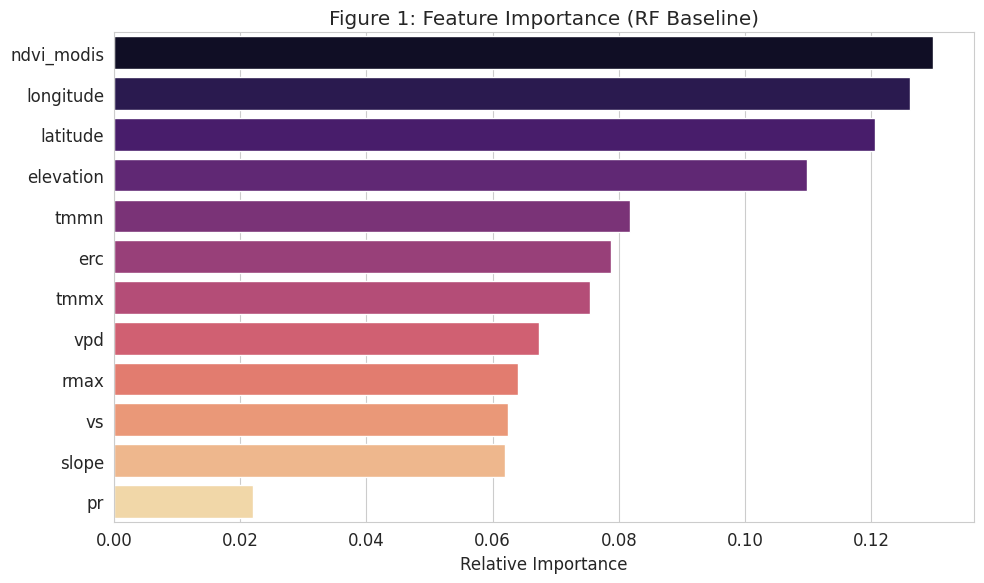

In [4]:
# training random forest
print("Training Baseline RF...")
# using seed here specifically for the classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
rf_model.fit(X_train, y_train)

# evaluating
y_pred = rf_model.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)
print(f"Baseline Accuracy: {baseline_acc:.4f}")
print(classification_report(y_test, y_pred))

# ploting importance for GA weights comparison later
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=[features[i] for i in indices], palette="magma")
plt.title("Figure 1: Feature Importance (RF Baseline)")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.savefig("Figure1_FeatureImportance.png", dpi=300)
plt.show()

### 5. Optimization Check

In [5]:
# checking if tunning improves the performance
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

print("Running Grid Search (approx 1-2 mins)...")
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=SEED, n_jobs=-1),
    param_grid, cv=3, scoring='accuracy', n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
opt_acc = accuracy_score(y_test, best_rf.predict(X_test))

print(f"Optimized Accuracy: {opt_acc:.4f}")
print(f"Improvement over baseline: {(opt_acc - baseline_acc)*100:.2f}%")

Running Grid Search (approx 1-2 mins)...
Optimized Accuracy: 0.8720
Improvement over baseline: 0.25%


### 6. Genetic Algorithm (Physics only)
Initial implementation to find high-risk zones using only physics rules (Fuel + Slope + Dryness) and no historical bonus in fitness scores.

In [6]:
# --- CONFIG ---
FROZEN_POP_SIZE = 300       
FROZEN_GENERATIONS = 50     
FROZEN_MUTATION = 0.3       
FROZEN_ELITISM = 3          
FROZEN_FEATURES = ['latitude', 'longitude', 'ndvi_modis', 'elevation', 'slope', 'erc']

class SpatialFireGA:
    def __init__(self, data_df, features, pop_size, generations, mutation_rate, elitism_count):
        self.df = data_df.reset_index(drop=True)
        self.pop_size = pop_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.elitism_count = elitism_count
        
        self.coords = self.df[['latitude', 'longitude']].values
        self.tree = cKDTree(self.coords)
        
        self.normalized_df = self.df[features].copy()
        for col in features:
            mn, mx = self.normalized_df[col].min(), self.normalized_df[col].max()
            if mx > mn:
                self.normalized_df[col] = (self.normalized_df[col] - mn) / (mx - mn)

    def fitness_function(self, lat, lon):
        dist, idx = self.tree.query([lat, lon], k=1)
        if dist > 0.1: return 0.0
        
        vals = self.normalized_df.iloc[idx]
        return (vals['ndvi_modis'] ** 2) * vals['erc'] * (1.0 + 0.5 * vals['slope'])

    def run(self):
        random.seed(SEED)
        np.random.seed(SEED)
        population = []
        attempts = 0
        
        
        # Looking for LOW RISK zones (safe).
        # This ensures the GA has to "travel" to find the fire.
        
        while len(population) < self.pop_size:
            # 1. Pick a random valid land point from data (No ocean guessing)
            idx = random.randint(0, len(self.df) - 1)
            row = self.df.iloc[idx]
            lat, lon = row['latitude'], row['longitude']
            
            # 2. Add jitter
            lat += random.uniform(-0.05, 0.05)
            lon += random.uniform(-0.05, 0.05)
            
            score = self.fitness_function(lat, lon)
            
            # 3. THE CONSTRAINT: Only accept if it's "Safe" (< 0.2) 
            # AND "Valid" (> 0.0, so not ocean)
            if 0.0 < score < 0.2:
                population.append([lat, lon])
                attempts = 0
            else:
                attempts += 1
            
            # Fail-safe: If we can't find enough "safe" spots, just take any valid land
            if attempts > 1000:
                if score > 0.0: # Accept any land
                    population.append([lat, lon])

        population = np.array(population)

        history_best = []
        history_fit = []
        
        for gen in range(self.generations):
            scores = np.array([self.fitness_function(ind[0], ind[1]) for ind in population])
            
            best_idx = np.argmax(scores)
            history_best.append(population[best_idx])
            history_fit.append(scores[best_idx])
            
            sorted_indices = np.argsort(scores)[::-1]
            survivors = population[sorted_indices[:self.pop_size // 2]]
            new_pop = [population[i] for i in sorted_indices[:self.elitism_count]]
            
            while len(new_pop) < self.pop_size:
                p1 = survivors[random.randint(0, len(survivors) - 1)]
                p2 = survivors[random.randint(0, len(survivors) - 1)]
                child = (p1 + p2) / 2.0
                
                if random.random() < self.mutation_rate:
                    step = 0.5 if random.random() < 0.2 else 0.05
                    child += np.random.uniform(-step, step, size=2)
                
                new_pop.append(child)
            
            population = np.array(new_pop)
            
        return np.array(history_best), history_fit

# Helper to plot
def plot_showdown(df, path, title, prob_threshold=0.7):
    rf_probs = rf_model.predict_proba(df[features])[:, 1]
    
    plt.figure(figsize=(10, 8))
    plt.scatter(df['longitude'], df['latitude'], c='lightgrey', s=30, alpha=0.3, label='Safe')
    
    high_risk = df[rf_probs > prob_threshold]
    if len(high_risk) > 0:
        plt.scatter(high_risk['longitude'], high_risk['latitude'], c='orange', s=40, alpha=0.6, label='RF Risk')
        
    fires = df[df['Wildfire_label'] == 1]
    if len(fires) > 0:
        plt.scatter(fires['longitude'], fires['latitude'], c='red', s=20, label='Actual Fire')
        
    if len(path) > 0:
        plt.plot(path[:, 1], path[:, 0], 'b--', alpha=0.6, linewidth=1.5, label='Search Path')
        plt.scatter(path[-1, 1], path[-1, 0], c='blue', marker='*', s=400, edgecolors='white', zorder=10, label='GA Result')
    
    plt.title(title)
    plt.legend(loc='lower left')
    plt.show()

### 7. GA Experiments (Physics only)

--- EXPERIMENT A: GA (NO HISTORY) ---
Running Countrywide...


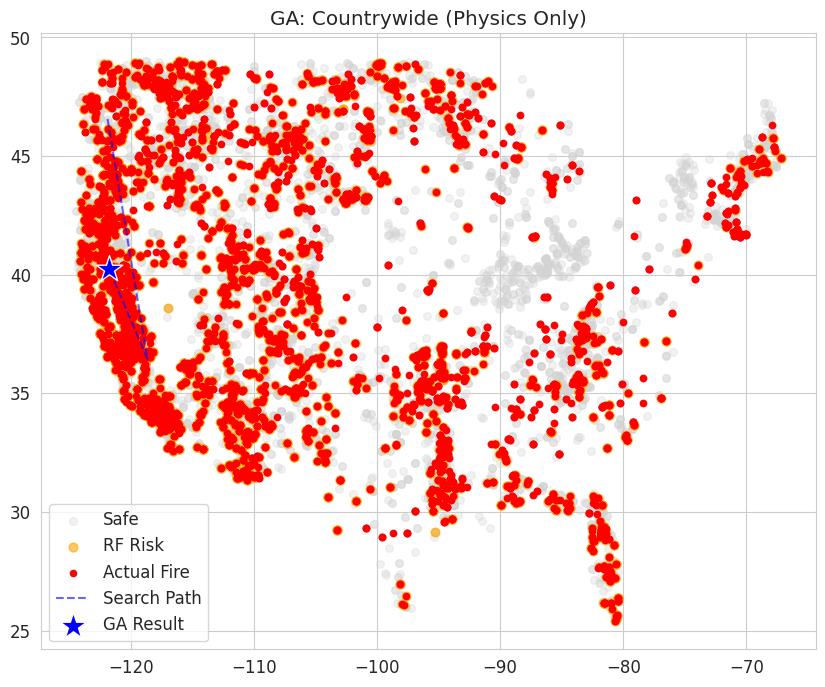

Running Targeted Region...


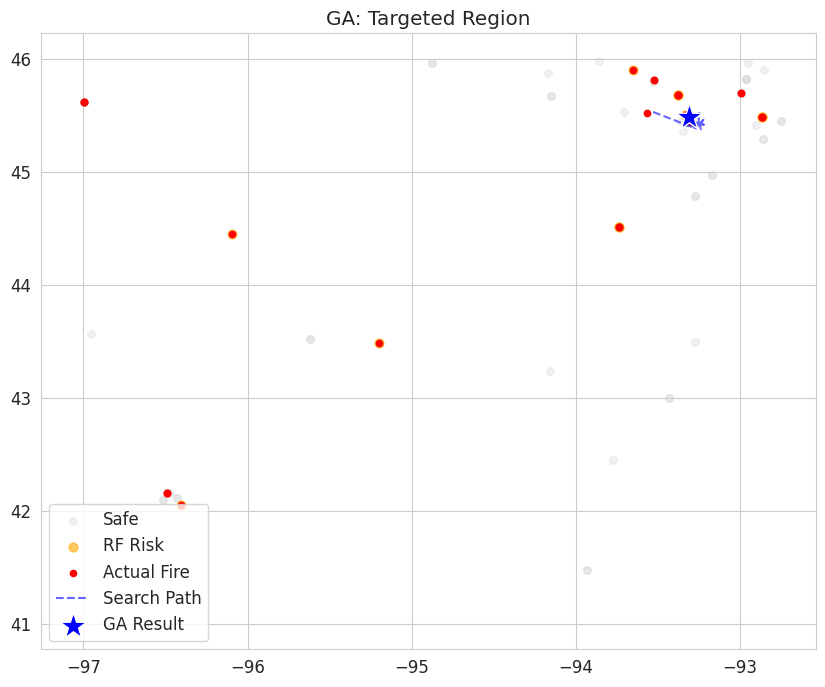

In [7]:
print("--- EXPERIMENT A: GA (NO HISTORY) ---")

# 1. Countrywide
print("Running Countrywide...")
ga_country = SpatialFireGA(test_df, FROZEN_FEATURES, FROZEN_POP_SIZE, FROZEN_GENERATIONS, FROZEN_MUTATION, FROZEN_ELITISM)
path_country, _ = ga_country.run()
plot_showdown(test_df, path_country, "GA: Countrywide (Physics Only)")

# 2. Targeted (Near a real fire)
print("Running Targeted Region...")
fire_rows = test_df[test_df['Wildfire_label'] == 1]
if len(fire_rows) > 0:
    center = fire_rows.sample(1, random_state=SEED).iloc[0] # seeded sample
    # create box around fire
    box_df = test_df[
        (test_df['latitude'].between(center['latitude']-2.5, center['latitude']+2.5)) &
        (test_df['longitude'].between(center['longitude']-2.5, center['longitude']+2.5))
    ].copy()
    
    ga_target = SpatialFireGA(box_df, FROZEN_FEATURES, FROZEN_POP_SIZE, FROZEN_GENERATIONS, FROZEN_MUTATION, FROZEN_ELITISM)
    path_target, _ = ga_target.run()
    plot_showdown(box_df, path_target, "GA: Targeted Region")
else:
    print("No fires in test set.")

### 8. Consistency Check & Micro-Scenarios
Checking if the algorithm is stable across multiple runs, and testing it on a specific urban interface (Los Angeles) to see if it detects future risks.

In [8]:
# checking stability over 5 runs
NUM_RUNS = 5
OUTPUT_DIR = "GA_Consistency"
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

print(f"Starting {NUM_RUNS} consistency runs...")

for i in range(1, NUM_RUNS + 1):
    # Run GA
    ga_run = SpatialFireGA(test_df, FROZEN_FEATURES, FROZEN_POP_SIZE, FROZEN_GENERATIONS, FROZEN_MUTATION, FROZEN_ELITISM)
    path, _ = ga_run.run()
    
    plt.figure(figsize=(10, 8))
    
    # 1. Background (Grey)
    plt.scatter(test_df['longitude'], test_df['latitude'], c='lightgrey', s=10, alpha=0.5, label='Safe Zone')
    
    # 2. Actual Fires (Red) - RESTORED THIS LAYER
    fires = test_df[test_df['Wildfire_label'] == 1]
    if len(fires) > 0:
        plt.scatter(fires['longitude'], fires['latitude'], c='red', s=10, alpha=0.5, label='Actual Fire')
    
    # 3. GA Trajectory (Blue)
    if len(path) > 0:
        plt.plot(path[:, 1], path[:, 0], 'b--', linewidth=1.5, alpha=0.7, label='Search Path')
        plt.scatter(path[-1, 1], path[-1, 0], c='blue', marker='*', s=300, edgecolors='white', zorder=10, label='GA Result')
        
    plt.title(f"Run {i}/{NUM_RUNS}: Consistency Check")
    plt.legend(loc='lower left')
    
    # Save
    save_path = f"{OUTPUT_DIR}/Run_{i}.png"
    plt.savefig(save_path)
    plt.close() # Close to save memory

print("Consistency check done. Images now show fires.")

Starting 5 consistency runs...
Consistency check done. Images now show fires.


### 9. LA Micro-Scenario (Physics only)

LA Region Points: 1442


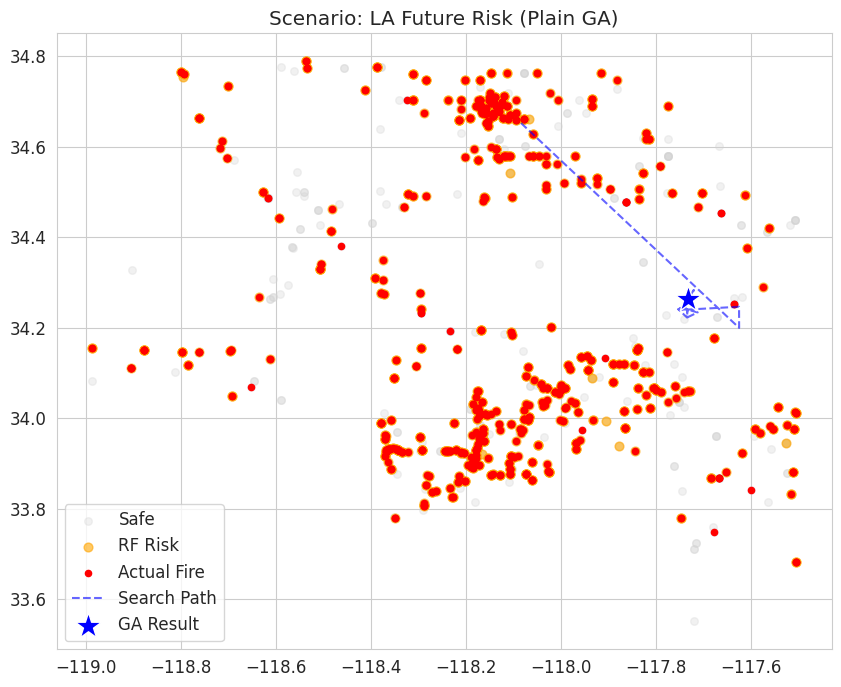

In [9]:
# LA Box
LA_LAT = (33.5, 34.8)
LA_LON = (-119.0, -117.5)

la_df = test_df[
    (test_df['latitude'].between(*LA_LAT)) & 
    (test_df['longitude'].between(*LA_LON))
].copy()

print(f"LA Region Points: {len(la_df)}")

if len(la_df) > 20:
    ga_la = SpatialFireGA(la_df, FROZEN_FEATURES, 200, 40, 0.3, 3)
    path_la, _ = ga_la.run()
    plot_showdown(la_df, path_la, "Scenario: LA Future Risk (Plain GA)")
else:
    print("Not enough data for LA.")

### 10. New GA (Physics + Hystorical) 

**Problem:** The Plain GA sometimes misses areas that are physically "safe" (low slope) but historically "hot" (frequent ignition).

**Solution:** Injected a bonus into the fitness function using the Training set. If an area has a history of fire, we boost its risk score.

In [10]:
# setting up the data for the audit
print("Preparing Temporal Splits...")

if 'datetime' in la_df.columns:
    la_df['datetime'] = pd.to_datetime(la_df['datetime'])
else:
    # Fallback if your column has a different name (e.g., 'acq_date')
    # Update 'acq_date' to whatever your date column is actually named
    if 'acq_date' in la_df.columns:
        la_df['datetime'] = pd.to_datetime(la_df['acq_date'])

# Dataset A: All history
la_all = la_df.copy()

# Dataset B: 2021 Snapshot
# Now this will work because .dt accessor is valid on datetime objects
la_2021 = la_df[la_df['datetime'].dt.year == 2021].copy()

print(f"Full History: {len(la_all)} points")
print(f"2021 Snapshot: {len(la_2021)} points")

Preparing Temporal Splits...
Full History: 1442 points
2021 Snapshot: 207 points


### 11. New GA (Hysics + Historical Bonus)

In [11]:
# --- 1. Build Memory ---
# we use the training set to build the memory, so no data leakage
train_fires = train_df[train_df['Wildfire_label'] == 1][['latitude', 'longitude']].values
history_tree = cKDTree(train_fires) if len(train_fires) > 0 else None
print(f"Historical Memory Tree: {len(train_fires)} fires indexed.")

# --- 2. Improved Class ---
class SpatialFireGA_History(SpatialFireGA):
    """
    Inherits from Plain GA. 
    Adds 'Historical Bonus' to fitness function.
    """
    def __init__(self, data_df, features, pop_size, generations, mutation_rate, elitism_count, 
                 history_tree, history_weight=0.5):
        # init parent
        super().__init__(data_df, features, pop_size, generations, mutation_rate, elitism_count)
        self.history_tree = history_tree
        self.history_weight = history_weight

    def fitness_function(self, lat, lon):
        # A. Base Physics Score (copied logic from parent)
        dist, idx = self.tree.query([lat, lon], k=1)
        if dist > 0.1: return 0.0
        vals = self.normalized_df.iloc[idx]
        
        base_score = (vals['ndvi_modis'] ** 2) * vals['erc'] * (1.0 + 0.5 * vals['slope'])
        
        # B. Historical Bonus
        hist_bonus = 0.0
        if self.history_tree:
            # check distance to nearest PAST fire
            h_dist, _ = self.history_tree.query([lat, lon], k=1)
            # exponential decay: closer to past fire = bigger bonus
            hist_bonus = np.exp(-h_dist / 0.05) 
            
        # C. Combine
        return base_score * (1.0 + (self.history_weight * hist_bonus))

print("Fresh GA Class defined.")

Historical Memory Tree: 39097 fires indexed.
Fresh GA Class defined.


### 12. GA (Physics + Historical) Experiment

--- EXPERIMENT B: FRESH GA (WITH HISTORY) ---


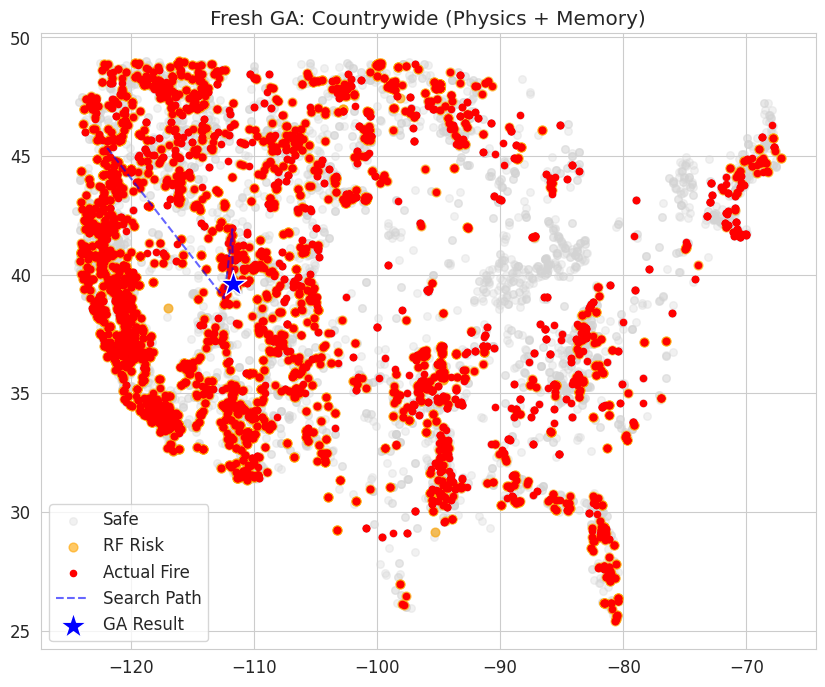

Running Temporal Audit on LA...


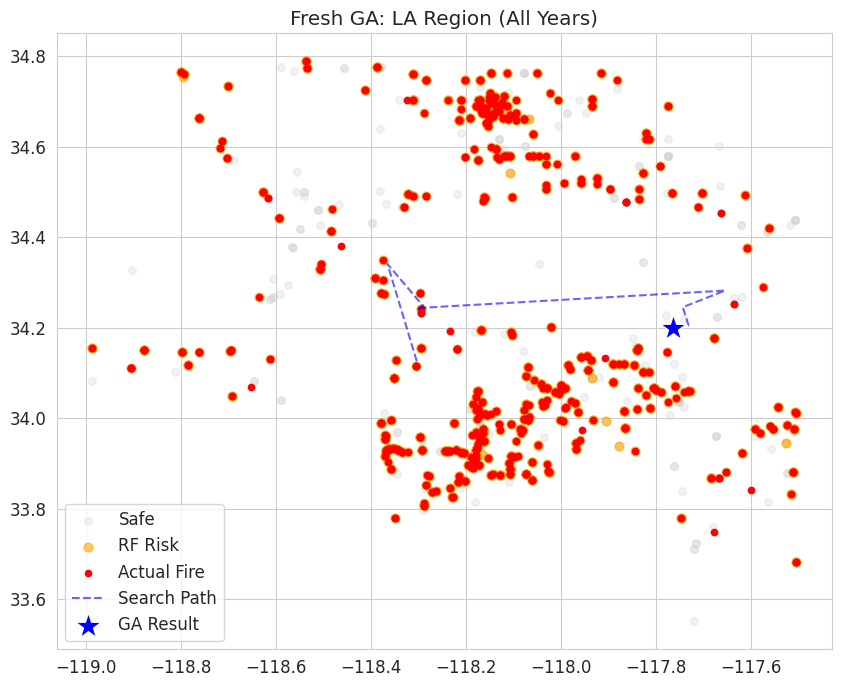

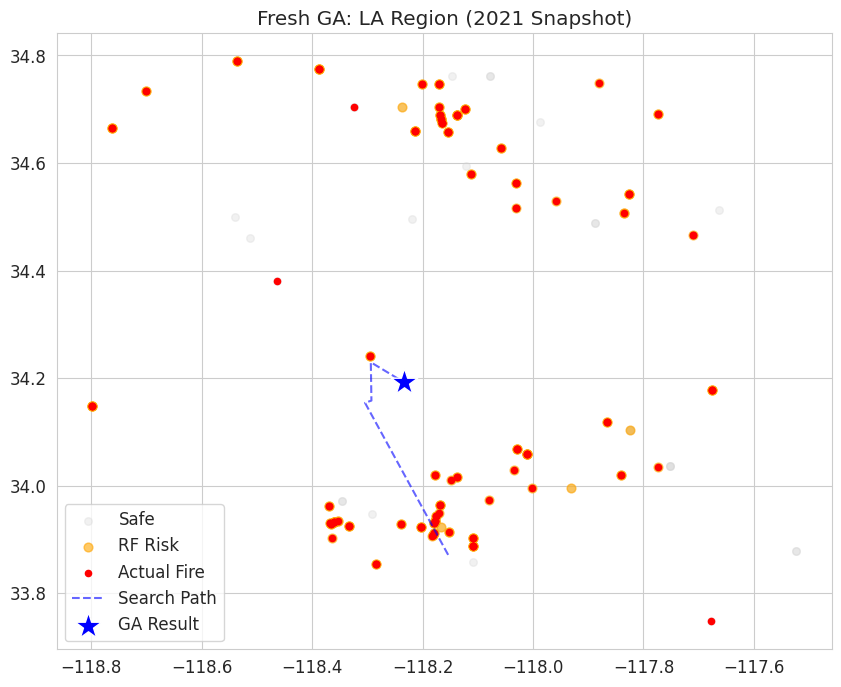

In [12]:
print("--- EXPERIMENT B: FRESH GA (WITH HISTORY) ---")

def run_comparison(df, name):
    if len(df) < 20: return
    
    # Run the new GA
    ga_fresh = SpatialFireGA_History(
        df, FROZEN_FEATURES, 200, 40, 0.3, 3,
        history_tree=history_tree
    )
    path, _ = ga_fresh.run()
    
    # Plot results
    plot_showdown(df, path, f"Fresh GA: {name}")

# 1. Re-run Countrywide to see difference
run_comparison(test_df, "Countrywide (Physics + Memory)")

# 2. Re-run LA Scenarios (Temporal Audit)
print("Running Temporal Audit on LA...")
run_comparison(la_all, "LA Region (All Years)")
run_comparison(la_2021, "LA Region (2021 Snapshot)")